In [1]:
import os
import pickle
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import statsmodels.api as sm
from sklearn.linear_model import QuantileRegressor, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_pinball_loss

# = = = = = =
# own stuff
# = = = = = =
# os.chdir("C:/2023_11-PTSFC")
os.chdir("C:/2023_11-PTSFC")
import data_prepro as data_prepro
import model_train as model_train
import model_fcast as model_fcast
# from data_prepro import get_energy_data_today, create_dummy_df, create_features_df

### Params

In [2]:
os.environ["LOKY_MAX_CPU_COUNT"] = "1"  # Replace "4" with the desired number of cores

quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
fcast_hor = [36, 40, 44, 60, 64, 68] # in hours

# = = = = = = = = = = = = = 
# >>> generate prediction timestamps based on t0 = following thursday 00:00 dynamically
# = = = = = = = = = = = = = 

# - - - - - - - - - - - - - 
# get current date and set time to 00:00
t_now = pd.Timestamp.now(tz='CET').replace(hour=0, minute=0, second=0, microsecond=0)

# - - - - - - - - - - - - - 
# get thursday and wednesday
days_left = 3 - t_now.weekday() # get days left till thursday
t_thursday = t_now + pd.Timedelta(days=days_left)
t_wednesday = t_thursday - pd.Timedelta(days=1)
print(f"wed = {t_wednesday}")
print(f"thu = {t_thursday}")

# - - - - - - - - - - - - - 
# get required submission horizons
# based on fcast horizons generate timestamps from t0
subm_timestamps = []
for fcast in fcast_hor:
    subm_timestamps.append((t_thursday + pd.Timedelta(hours=fcast)))
print(subm_timestamps)

wed = 2024-01-31 00:00:00+01:00
thu = 2024-02-01 00:00:00+01:00
[Timestamp('2024-02-02 12:00:00+0100', tz='CET'), Timestamp('2024-02-02 16:00:00+0100', tz='CET'), Timestamp('2024-02-02 20:00:00+0100', tz='CET'), Timestamp('2024-02-03 12:00:00+0100', tz='CET'), Timestamp('2024-02-03 16:00:00+0100', tz='CET'), Timestamp('2024-02-03 20:00:00+0100', tz='CET')]


### Data Prep

In [3]:
# = = = = = = = = = = = = = 
# get data
df_energy = data_prepro.get_energy_data_today(to_date=t_wednesday.strftime('%Y%m%d'))

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# take smaller dataset
start   = '2018-01-01'
end     = df_energy['timestamp_CET'].max()
df_energy_small = df_energy.loc[(df_energy['timestamp_CET'] > start) &
                                (df_energy['timestamp_CET'] <= end)]

print('- '*15)
print(f"take smaller dataset ... from {start} to {end}")
print(df_energy_small.info())

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# feature engineering and preparing training data

df_energy_dummy = data_prepro.create_dummy_df(df_energy_small, hour_method='seasonal', holiday_method='separate')
df_energy_fturs = data_prepro.create_features_df(df_energy_small, holiday_method='separate', lags=[24, 7*24])

X_train_fturs = df_energy_fturs.drop(['gesamt', 'timestamp_CET'], axis=1)
y_train_fturs = df_energy_fturs['gesamt']

X_train_dummy = df_energy_dummy.drop(['gesamt', 'timestamp_CET'], axis=1)
y_train_dummy = df_energy_dummy['gesamt']

> cwd = C:\2023_11-PTSFC
> to_date is later than 2023-11-01, using recent data as well !


100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


> 0 NA in df
> last valid index = 2024-01-31 21:30:00+00:00
> done and saved to 2015-01-01_2024-01-31_energy.csv
- - - - - - - - - - - - - - - 
take smaller dataset ... from 2018-01-01 to 2024-01-31 22:00:00+01:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53326 entries, 2018-01-01 00:00:00+00:00 to 2024-01-31 21:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  53326 non-null  datetime64[ns, CET]
 1   gesamt         53326 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.2 MB
None


### Model Train

In [4]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# train models 
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# quantile regression with dummies
all_models_quant_reg = model_train.fit_quant_reg(X_train_dummy, y_train_dummy, quantiles=quantiles)
# gradient boosting with features
all_models_grad_boost = model_train.fit_grad_boost(X_train_fturs, y_train_fturs, quantiles=quantiles)

- - - - - - - - - - - - - - - 
> start training quantile regression models ...
>> alpha = 0.025 ...
>> alpha = 0.250 ...
>> alpha = 0.500 ...
>> alpha = 0.750 ...
>> alpha = 0.975 ...
- - - - - - - - - - - - - - - 
> time taken: 1173.26 seconds
- - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - 
> start training gradient boosting models ...
>> alpha = 0.025 ...
>> alpha = 0.250 ...
>> alpha = 0.500 ...
>> alpha = 0.750 ...
>> alpha = 0.975 ...
- - - - - - - - - - - - - - - 
> time taken: 545.20 seconds
- - - - - - - - - - - - - - - 


In [5]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# save trained models

fname_time = t_wednesday.strftime('%Y_%m_%d')
path = f"./submissions/{fname_time}"
if not os.path.exists(path):
    os.makedirs(path)

train_start = X_train_dummy.index.min().strftime('%Y%m%d')
train_end = X_train_dummy.index.max().strftime('%Y%m%d')

with open(f'{path}/{train_start}_{train_end}_all_models_quant_reg.pickle', 'wb') as handle:
    pickle.dump(all_models_quant_reg, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'{path}/{train_start}_{train_end}_all_models_grad_boost.pickle', 'wb') as handle:
    pickle.dump(all_models_grad_boost, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Iterative Ensemble Forecast from Thursday

first input dataframe from 2024-01-24 21:00:00+00:00 to 2024-01-31 21:00:00+00:00
- - - - - - - - - - - - - - - 
> to be forecasted
2024-02-03 22:00:00+00:00 to 2024-02-04 21:00:00+00:00
= = = = = = = = = = = = = = = 
all iterative fcasts done ...


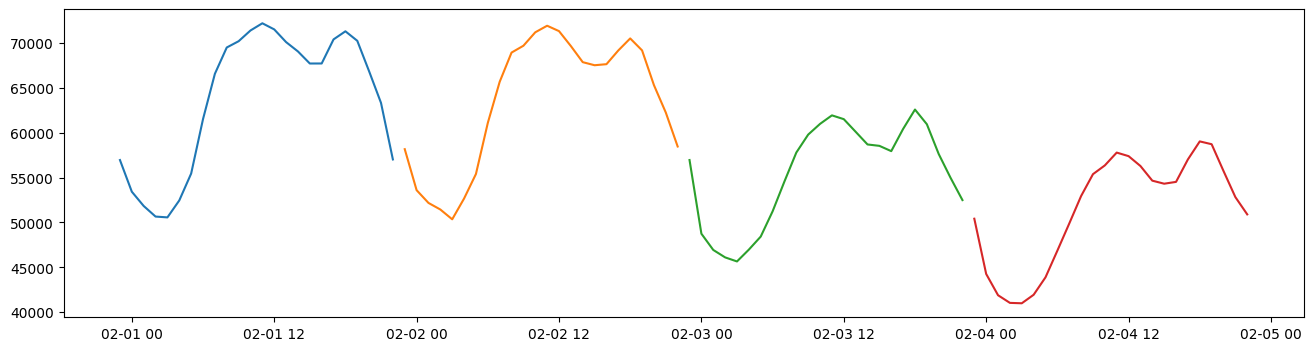

,q 0.025,q 0.250,q 0.500,q 0.750,q 0.975
2024-01-31 22:00:00+00:00,50267.776380,55022.819249,56957.525745,58342.481115,62884.496136
2024-01-31 23:00:00+00:00,48521.389268,51902.862218,53427.677283,55471.811659,58537.222508
2024-02-01 00:00:00+00:00,46853.822168,49899.307430,51837.027543,53333.565519,55608.282971
2024-02-01 01:00:00+00:00,45217.587703,49186.948782,50658.361498,52397.292684,54809.979468
2024-02-01 02:00:00+00:00,45537.415278,49203.543163,50566.329168,52409.405199,54503.569124
...,...,...,...,...,...
2024-02-04 17:00:00+00:00,53974.721136,56298.841793,59035.966574,61751.623600,63935.618696
2024-02-04 18:00:00+00:00,53069.611102,55603.743032,58722.523947,60345.015764,62946.609899
2024-02-04 19:00:00+00:00,50249.895004,53182.644847,55739.255868,57174.497208,59250.088183
2024-02-04 20:00:00+00:00,47972.109444,51143.604612,52827.870617,54558.282945,56952.272596


In [6]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# take smaller dataset to create future features for fcast
end     = df_energy.index.max()
start   = df_energy.index.max()-pd.Timedelta(days=7)
print(f"first input dataframe from {start} to {end}")

# this dataframe has values of past 7 days = last week
# because in the first step we predict the next 12 hours
# and we need the lagged values of last week for grad boost features
df_energy_small = df_energy.loc[(df_energy.index > start) &
                                (df_energy.index <= end)]

df_fcast_iter_all = pd.DataFrame()
iterations = 4
iteration_length = 24

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# fig, axes = plt.subplots(1, iterations, figsize=(iterations*8,4))
# axes = axes.flatten()
fig, ax = plt.subplots(1, 1, figsize=(16,4))

print('- '*15) 
print(f"> to be forecasted")
for fcast_iter in range(iterations):

    if fcast_iter > 0:
        df_energy_small = pd.concat((df_energy_small, df_ens_fcast_loop))
        end = df_energy_small.index.max()
        # print(f"new end timestamp: {end}")

    # add fcast index for next iteration_length hours
    fcast_timestamp_UTC = pd.date_range(start=end, periods=iteration_length+1, freq='H')[1:]
    fcast_timestamp_CET = fcast_timestamp_UTC.tz_convert('CET')

    print(f"{fcast_timestamp_UTC.min()} to {fcast_timestamp_UTC.max()}", end='\r')

    # create df with timestamps of next iteration_length hours
    df_temp = pd.DataFrame(index=fcast_timestamp_UTC)
    df_temp['timestamp_CET'] = fcast_timestamp_CET

    # add to dataframe as new rows with NaN values in gesamt column
    df_fcast = pd.concat((df_energy_small, df_temp))

    # use data from last week for features
    # take only the last iteration_length rows
    df_fcast_fturs = data_prepro.create_features_df(df_fcast, holiday_method='separate', lags=[24, 7*24]).tail(iteration_length)
    df_fcast_dummy = data_prepro.create_dummy_df(df_fcast, hour_method='seasonal', holiday_method='separate').tail(iteration_length)

    # print(df_fcast_dummy.index)
    # print(df_fcast_fturs.index)

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
    # fcast

    # save fcast in df with columns = quantiles
    df_quant_reg_fcast = pd.DataFrame(index=df_fcast_dummy.index)
    df_grad_boost_fcast = pd.DataFrame(index=df_fcast_fturs.index)

    # Prediction for Quantile Regression
    for name, quant_reg_model in sorted(all_models_quant_reg.items()):
        pred = quant_reg_model.predict(df_fcast_dummy.drop(['gesamt', 'timestamp_CET'], axis=1))
        df_quant_reg_fcast[name] = pred

    # Prediction for Gradient Boosting
    for name, grad_boost_model in sorted(all_models_grad_boost.items()):
        pred = grad_boost_model.predict(df_fcast_fturs.drop(['gesamt', 'timestamp_CET'], axis=1))
        df_grad_boost_fcast[name] = pred

    # take ensemble of q 0.500 of both models
    ens_fcast = (df_quant_reg_fcast['q 0.500'].values + df_grad_boost_fcast['q 0.500'].values) / 2
    df_ens_fcast_loop = pd.DataFrame(index=df_quant_reg_fcast.index)
    df_ens_fcast_loop['timestamp_CET'] = df_ens_fcast_loop.index.tz_convert('CET')
    df_ens_fcast_loop['gesamt'] = ens_fcast
    df_ens_fcast_loop

    # plt.figure(figsize=(8,2))
    # ax = axes[fcast_iter]
    ax.plot(df_ens_fcast_loop['timestamp_CET'], ens_fcast)

    # save fcast to df
    df_ens_fcast_out = (df_quant_reg_fcast * 0.5 + df_grad_boost_fcast * 0.5)
    df_ens_fcast_out = df_ens_fcast_out.groupby(df_ens_fcast_out.index).mean()
    df_fcast_iter_all = pd.concat((df_fcast_iter_all, df_ens_fcast_out))

print('')
print('= '*15)
print(f"all iterative fcasts done ...")

plt.show()
display(df_fcast_iter_all)

#### Fix QC & Save to csv

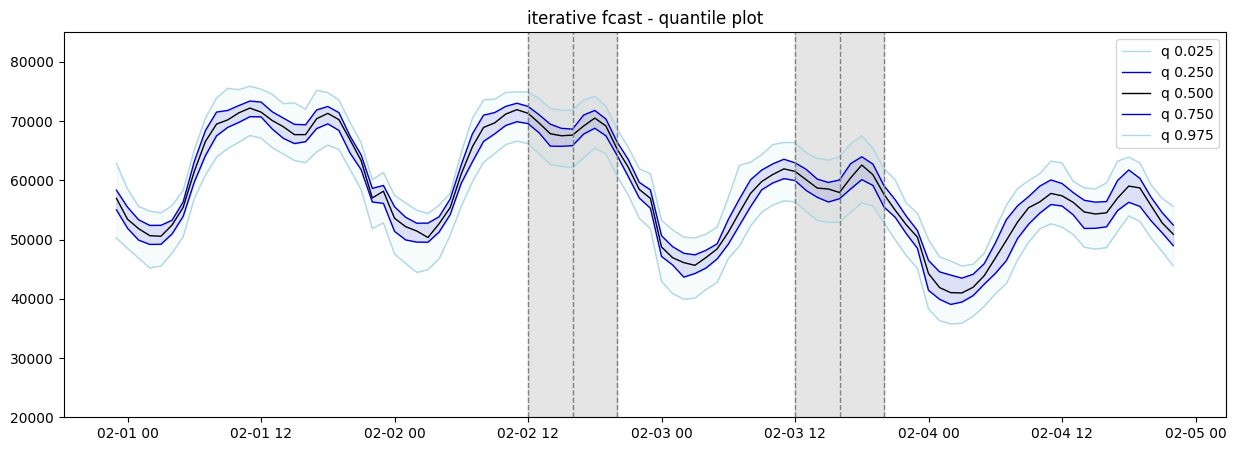

In [7]:
# - - - - - - - - - - - - - 
# fix quantile crossing
df_iter_fcast_all_fixed = data_prepro.fix_quantile_crossing(df_fcast_iter_all)
# current fcast index is based on UTC only, add CET col
df_iter_fcast_all_fixed['timestamp_CET'] = df_iter_fcast_all_fixed.index.tz_convert('CET')
# reorder cols
df_iter_fcast_all_fixed = df_iter_fcast_all_fixed[['timestamp_CET', 'q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']]

# - - - - - - - - - - - - - 
# plot + highlight submission horizons
model_train.plot_quantile_fcast(df_iter_fcast_all_fixed, subm_timestamps, title='iterative fcast')

# - - - - - - - - - - - - - 
# if folder with name {current wednesday} does not exists in 2023_11-PTSFC/submissions/... create it
# if folder exists ... save csv to it

fname_time = t_wednesday.strftime('%Y_%m_%d')
path = f"./submissions/{fname_time}"
if not os.path.exists(path):
    os.makedirs(path)

# save entire iterative fcast to csv
df_iter_fcast_all_fixed.to_csv(f"{path}/{fname_time}_power_iterative_fcast.csv", index=False)

### Direct h-step Quant Reg Fcast

In [8]:
# create fcast index for next 96 hours
end = df_energy.index.max()
fcast_timestamp_UTC = pd.date_range(start=end, periods=96+1, freq='H')[1:]
fcast_timestamp_CET = fcast_timestamp_UTC.tz_convert('CET')

print('- '*15) 
print(f"> to be forecasted")
print(f"{fcast_timestamp_UTC.min()} to {fcast_timestamp_UTC.max()}")

# create df with fcast timestamps 
df_temp = pd.DataFrame(index=fcast_timestamp_UTC)
df_temp['timestamp_CET'] = fcast_timestamp_CET
df_fcast_dummy = data_prepro.create_dummy_df(df_temp, hour_method='seasonal', holiday_method='separate')
# display(df_fcast_dummy)
# display(df_fcast_dummy.tail())

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# fcast

print('- '*15)    
print(f'> start prediction ...')

# save fcast in df with columns = quantiles
df_quant_reg_direct_fcast = pd.DataFrame(index=df_fcast_dummy.index)
df_quant_reg_direct_fcast['timestamp_CET'] = fcast_timestamp_CET

# Prediction for Quantile Regression
for name, quant_reg_model in sorted(all_models_quant_reg.items()):
    pred = quant_reg_model.predict(df_fcast_dummy.drop('timestamp_CET', axis=1))
    df_quant_reg_direct_fcast[name] = pred

- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-31 22:00:00+00:00 to 2024-02-04 21:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


#### Fix QC and Save

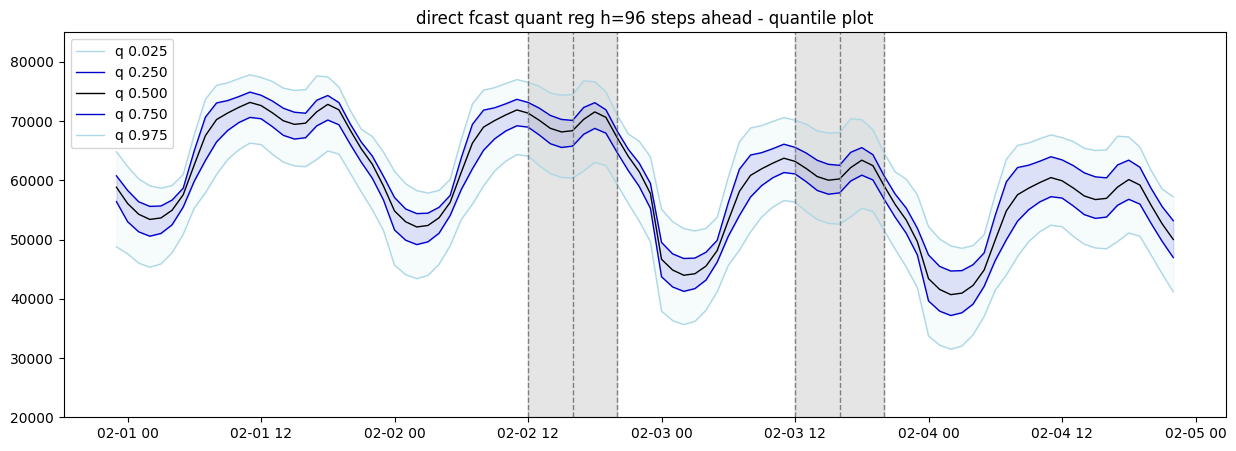

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-01-31,energy,36 hour,64.351375,69.21550,71.887125,73.68500,77.00875
1,2024-01-31,energy,40 hour,60.503750,65.56125,68.179375,70.28800,74.37725
2,2024-01-31,energy,44 hour,62.500000,67.96825,70.633250,71.91550,74.94625
3,2024-01-31,energy,60 hour,56.592750,61.31875,63.737500,66.10425,70.60475
4,2024-01-31,energy,64 hour,52.745125,57.66450,60.029750,62.70725,67.97325
5,2024-01-31,energy,68 hour,54.741375,60.07150,62.483625,64.33475,68.54225


In [9]:
# - - - - - - - - - - - - - 
# plot + highlight submission horizons
model_train.plot_quantile_fcast(df_quant_reg_direct_fcast, subm_timestamps, title='direct fcast quant reg h=96 steps ahead')

# - - - - - - - - - - - - - 
# get fcast values for required submission horizons
mask = df_quant_reg_direct_fcast['timestamp_CET'].isin(subm_timestamps) 
# shift mask by 1
mask = mask.shift(-1).fillna(False)
df_submission = df_quant_reg_direct_fcast.loc[mask,:]
# display(df_submission)

# - - - - - - - - - - - - - 
# turn to array and div by 1000
submission_arr = np.array(df_submission.iloc[:,1:]/1000)

df_sub = pd.DataFrame({
    
    "forecast_date": t_wednesday.strftime("%Y-%m-%d"), 
    "target": "energy",
    "horizon": [str(h) + " hour" for h in fcast_hor],
    "q0.025": submission_arr[:,0],
    "q0.25": submission_arr[:,1],
    "q0.5": submission_arr[:,2],
    "q0.75": submission_arr[:,3],
    "q0.975": submission_arr[:,4]

})

display(df_sub)

### Naive Benchmark

In [10]:
# - - - - - - - - - - - - - 
# create fcast index for next 96 hours
end = df_energy.index.max()
fcast_timestamp_UTC = pd.date_range(start=end, periods=96+1, freq='H')[1:]
fcast_timestamp_CET = fcast_timestamp_UTC.tz_convert('CET')

fcast_timestamps = fcast_timestamp_CET
# fcast_timestamps = subm_timestamps

# - - - - - - - - - - - - - 
df_energy_benchmark = df_energy.copy()
df_energy_benchmark["month"] = df_energy_benchmark['timestamp_CET'].dt.month
df_energy_benchmark["weekday"] = df_energy_benchmark['timestamp_CET'].dt.weekday # Monday=0, Sunday=6
df_energy_benchmark["weeknum"] = df_energy_benchmark['timestamp_CET'].dt.isocalendar().week

last_t = 100
methods = ['linear', 'median_unbiased', 'normal_unbiased', 'weibull']

number_of_matches_in_past = 0
pred_baseline = np.zeros((len(methods),len(fcast_timestamps),5))

for i,d in enumerate(fcast_timestamps):
        
    weekday = d.weekday()
    hour = d.hour
    weeknum = d.week
    
    # condition that the weekday and hour match AND the weeknum is within +/- 2 weeks of the target
    # cond = (df_energy_benchmark.weekday == weekday) & (df_energy_benchmark.index.time == d.time()) & (df_energy_benchmark['weeknum'].between(weeknum-2, weeknum+2)) 
    
    # alternatively:
    # condition that the weekday and hour match AND the month also matches
    # cond = (df_energy_benchmark.weekday == weekday) & (df_energy_benchmark.index.time == d.time()) & (df_energy_benchmark.index.month == d.month)

    # alternatively:
    # condition that the weekday and hour match AND the month is within +/- 1 months of the target
    cond = (df_energy_benchmark.weekday == weekday) & (df_energy_benchmark.index.time == d.time()) & (df_energy_benchmark['month'].between(d.month-1, d.month+1))

    match_df = df_energy_benchmark[cond]
    number_of_matches_in_past += match_df.shape[0] 

    for m_idx, method in enumerate(methods):
        pred_baseline[m_idx, i, :] = np.quantile(match_df.iloc[-last_t:]["gesamt"], q=quantiles, method=method)

number_of_matches_in_past = number_of_matches_in_past / len(fcast_timestamps)
print(f"avg number_of_matches_in_past = {number_of_matches_in_past:.2f}")

dict_benchmark_fcast = {}

for m_idx, method in enumerate(methods):

    print('- '*15)
    print(f"method = {method}")
    print('- '*15)
    
    df_benchmark = pd.DataFrame(index=fcast_timestamps, columns=[f"q {q:.3f}" for q in quantiles])
    df_benchmark.loc[:,:] = pred_baseline[m_idx,:,:]
    # - - - - - - - - - - - - - 
    # make sure all cols are float
    df_benchmark = df_benchmark.astype(float)
    # - - - - - - - - - - - - - 
    # add CET col
    df_benchmark['timestamp_CET'] = df_benchmark.index.tz_convert('CET')
    # reorder cols
    df_benchmark = df_benchmark[['timestamp_CET', 'q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']]
    # - - - - - - - - - - - - - 
    # display(df_benchmark)

    dict_benchmark_fcast[method] = df_benchmark

avg number_of_matches_in_past = 119.24
- - - - - - - - - - - - - - - 
method = linear
- - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - 
method = median_unbiased
- - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - 
method = normal_unbiased
- - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - 
method = weibull
- - - - - - - - - - - - - - - 


### MSTL

c:\Users\ytl_c\miniconda3\Lib\site-packages\statsforecast\core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


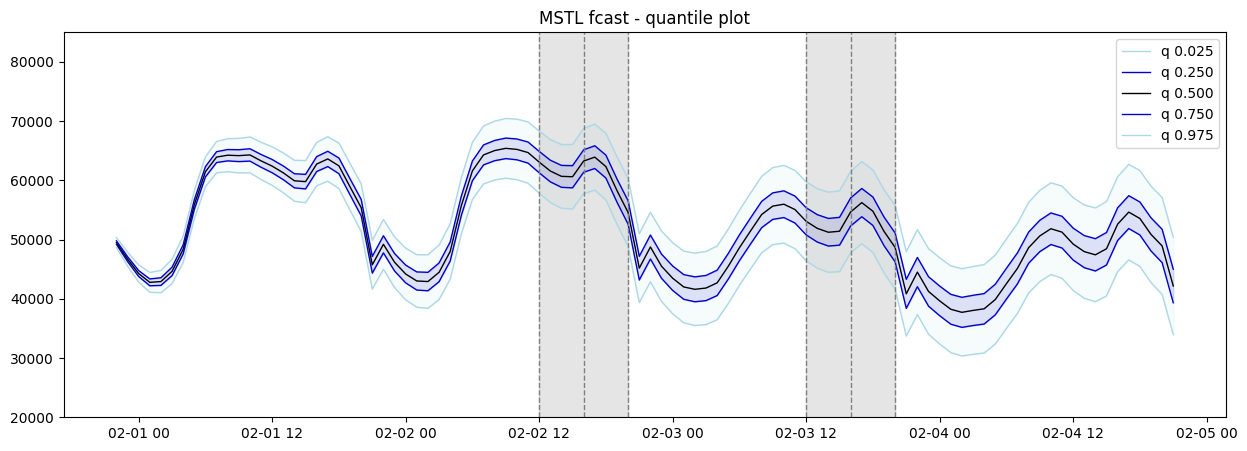

In [11]:
from statsforecast.models import MSTL

mstl_train_horizon = 0.5

df_mstl_train = df_energy.iloc[-int(mstl_train_horizon * 365 * 24) :].copy()
mstl_model = MSTL(season_length=[24, 24 * 7]).fit(df_mstl_train["gesamt"])

n_steps = 96

y_hat_dict = mstl_model.predict(h=n_steps, level=[50, 95])
y_hat_df = pd.DataFrame(y_hat_dict)
y_hat_df["timestamp_CET"] = pd.date_range(
    start=df_mstl_train["timestamp_CET"].max(), periods=len(y_hat_df), freq="H"
)

# rename columns
y_hat_df = y_hat_df.rename(
    columns={
        "mean": "q 0.500",
        "lo-50": "q 0.250",
        "hi-50": "q 0.750",
        "lo-95": "q 0.025",
        "hi-95": "q 0.975",
    }
)

y_hat_df = y_hat_df[
    ["timestamp_CET", "q 0.025", "q 0.250", "q 0.500", "q 0.750", "q 0.975"]
]
model_train.plot_quantile_fcast(y_hat_df, subm_timestamps, title="MSTL fcast")

df_mstl_fcast = y_hat_df
df_mstl_fcast.index = df_benchmark.index

### Compare all 3 fcasts next to each other

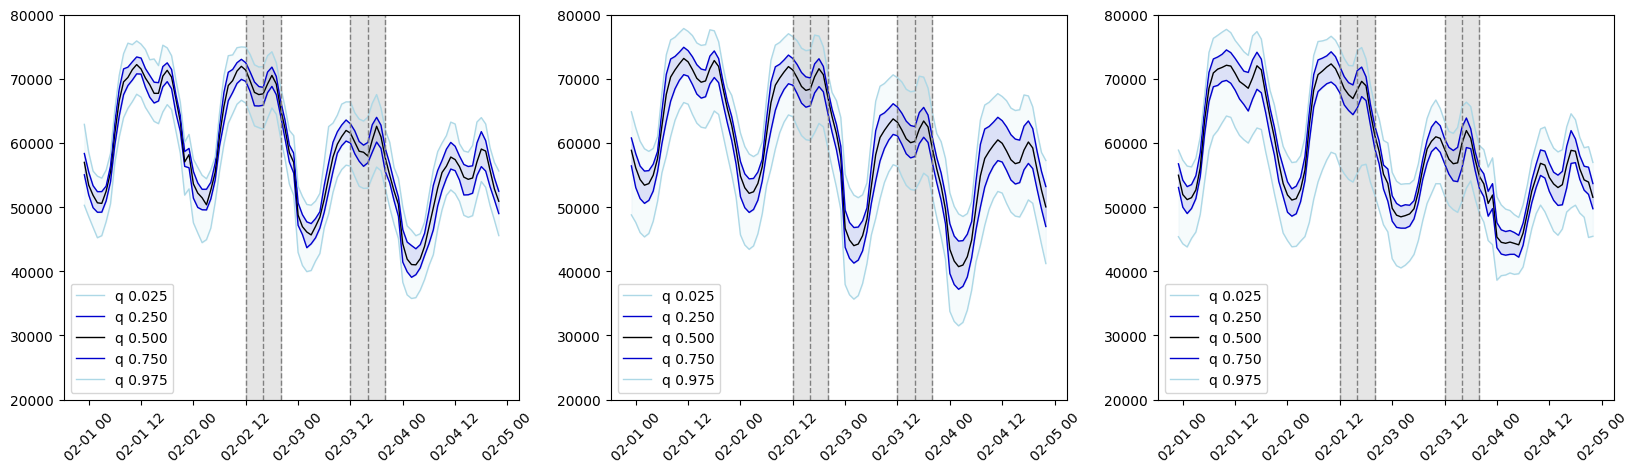

In [12]:
# df_iter_fcast_all_fixed
# dict_benchmark_fcast['linear']
# df_quant_reg_direct_fcast

fcasts = [df_iter_fcast_all_fixed, df_quant_reg_direct_fcast, dict_benchmark_fcast['linear']]
fig = plt.figure(figsize=(20,5))
x_range = pd.date_range(start=subm_timestamps[0], end=subm_timestamps[-1], freq='H')

for fcast_idx, fcast in enumerate(fcasts):

    # fcast = fcast.loc[fcast['timestamp_CET'].isin(x_range),:]
    ax = fig.add_subplot(1, 3, fcast_idx+1)

    cols = ['temp', 'lightblue', 'mediumblue', 'black', 'mediumblue', 'lightblue']

    for idx, quantile in enumerate(fcast.columns):
        if 'timestamp' in quantile:
            continue # skip timestamp column
        y_pred = fcast[quantile]
        ax.plot(fcast['timestamp_CET'], y_pred, label=f'{quantile}', lw=1, alpha=1, color=cols[idx])

    ax.fill_between(fcast['timestamp_CET'], fcast['q 0.025'], fcast['q 0.975'], color='lightblue', alpha=0.1)
    ax.fill_between(fcast['timestamp_CET'], fcast['q 0.250'], fcast['q 0.750'], color='mediumblue', alpha=0.1)

    ax.axvspan(subm_timestamps[0], subm_timestamps[2], alpha=0.2, color='grey')
    ax.axvspan(subm_timestamps[3], subm_timestamps[5], alpha=0.2, color='grey')

    # for timestamp in submission idx, make vertical line
    for timestamp in subm_timestamps:
        ax.axvline(timestamp, color='grey', linestyle='--', lw=1)

    # rotate x ticks
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    ax.set_ylim(20_000, 80_000)
    ax.legend()

plt.show()

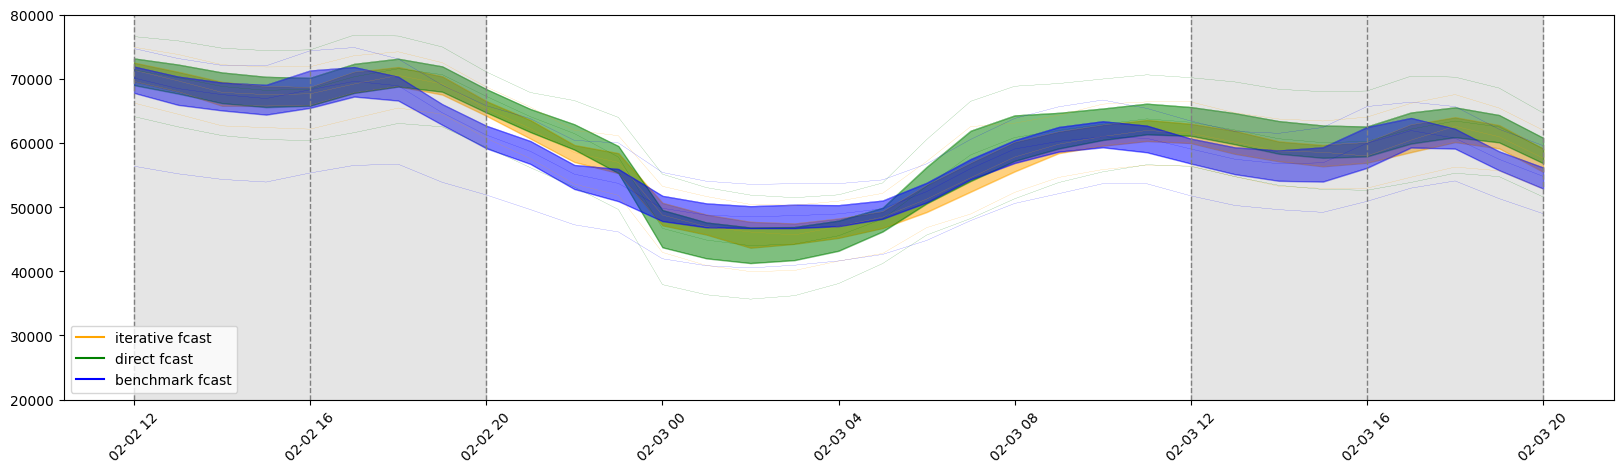

In [13]:
fig, ax = plt.subplots(figsize=(20, 5))
cols = ['orange', 'green', 'blue']

for fcast_idx, fcast in enumerate(fcasts):
    fcast = fcast.loc[fcast['timestamp_CET'].isin(x_range), :]

    for idx, quantile in enumerate(fcast.columns):
        if 'timestamp' in quantile:
            continue  # skip timestamp column
        y_pred = fcast[quantile]
        ax.plot(fcast['timestamp_CET'], y_pred, lw=0.1, alpha=1, color=cols[fcast_idx])

    # ax.fill_between(fcast['timestamp_CET'], fcast['q 0.025'], fcast['q 0.975'], color=cols[fcast_idx], alpha=0.2)
    ax.fill_between(fcast['timestamp_CET'], fcast['q 0.250'], fcast['q 0.750'], color=cols[fcast_idx], alpha=0.5)

# Add vertical spans and lines as per your original code
ax.axvspan(subm_timestamps[0], subm_timestamps[2], alpha=0.2, color='grey')
ax.axvspan(subm_timestamps[3], subm_timestamps[5], alpha=0.2, color='grey')

# for timestamp in submission idx, make vertical line
for timestamp in subm_timestamps:
    ax.axvline(timestamp, color='grey', linestyle='--', lw=1)

# Rotate x ticks
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# add manual legend
ax.plot([], [], color='orange', label='iterative fcast')
ax.plot([], [], color='green', label='direct fcast')
ax.plot([], [], color='blue', label='benchmark fcast')
ax.legend(loc='lower left')
ax.set_ylim(20_000, 80_000)
plt.show()

### Calc Total Ensemble

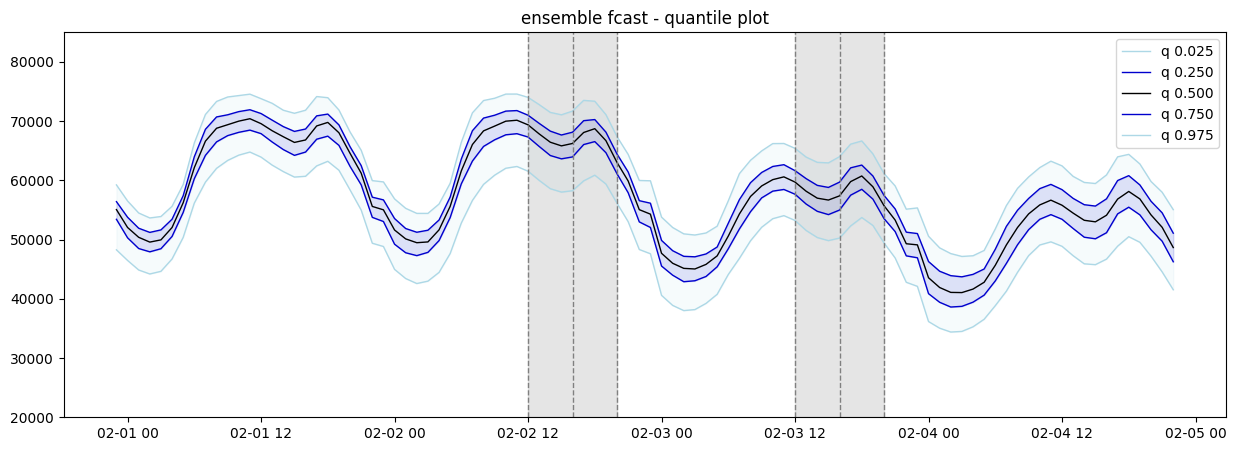

In [14]:
# average of all 3 fcasts with custom weighting
w_iter = 0.25
w_direct = 0.25
w_bench = 0.25
w_mstl = 0.25
                                             
# but ignore the first column "timestamp_CET" when calculating the average
df_ens_fcast = (df_iter_fcast_all_fixed.iloc[:,1:] * w_iter + 
                df_quant_reg_direct_fcast.iloc[:,1:] * w_direct + 
                dict_benchmark_fcast['linear'].iloc[:,1:] * w_bench + 
                df_mstl_fcast.iloc[:,1:] * w_mstl)

df_ens_fcast['timestamp_CET'] = df_iter_fcast_all_fixed['timestamp_CET']
# move timestamp col to first position
cols = df_ens_fcast.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_ens_fcast = df_ens_fcast[cols]
        
# plot
model_train.plot_quantile_fcast(df_ens_fcast, subm_timestamps, title='ensemble fcast')

### Create and Save Submission CSV File

In [15]:
# - - - - - - - - - - - - - 
# get fcast values for required submission horizons
mask = df_ens_fcast['timestamp_CET'].isin(subm_timestamps) 

df_submission = df_ens_fcast.loc[mask,:]
display(df_submission)

# - - - - - - - - - - - - - 
# turn to array and div by 1000
submission_arr = np.array(df_submission.iloc[:,1:]/1000)

df_sub = pd.DataFrame({
    
    "forecast_date": t_wednesday.strftime("%Y-%m-%d"), 
    "target": "energy",
    "horizon": [str(h) + " hour" for h in fcast_hor],
    "q0.025": submission_arr[:,0],
    "q0.25": submission_arr[:,1],
    "q0.5": submission_arr[:,2],
    "q0.75": submission_arr[:,3],
    "q0.975": submission_arr[:,4]

})

# - - - - - - - - - - - - - 
# if folder with name {current wednesday} does not exists in 2023_11-PTSFC/submissions/... create it
# if folder exists ... save csv to it

fname_time = t_wednesday.strftime('%Y_%m_%d')
path = f"./submissions/{fname_time}"
if not os.path.exists(path):
    os.makedirs(path)
    
# save submission fcast to csv
df_sub.to_csv(f"{path}/{fname_time}_power_fcast_submission.csv", index=False)
display(df_sub)

,timestamp_CET,q 0.025,q 0.250,q 0.500,q 0.750,q 0.975
2024-02-02 11:00:00+00:00,2024-02-02 12:00:00+01:00,61543.710337,67317.668903,69370.896200,71001.242691,74011.404009
2024-02-02 15:00:00+00:00,2024-02-02 16:00:00+01:00,58247.151247,63956.837696,66229.186052,68132.733199,71691.413435
2024-02-02 19:00:00+00:00,2024-02-02 20:00:00+01:00,56130.272872,61100.098449,63009.984324,64437.330418,67380.630677
2024-02-03 11:00:00+00:00,2024-02-03 12:00:00+01:00,53229.205730,57657.498940,59708.044363,61635.726430,65404.354217
2024-02-03 15:00:00+00:00,2024-02-03 16:00:00+01:00,50257.058582,54985.905742,57382.136591,59703.699768,64000.042136
2024-02-03 19:00:00+00:00,2024-02-03 20:00:00+01:00,49431.215474,53543.379161,55725.797638,57460.279230,61155.174951


,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-01-31,energy,36 hour,61.543710,67.317669,69.370896,71.001243,74.011404
1,2024-01-31,energy,40 hour,58.247151,63.956838,66.229186,68.132733,71.691413
2,2024-01-31,energy,44 hour,56.130273,61.100098,63.009984,64.437330,67.380631
3,2024-01-31,energy,60 hour,53.229206,57.657499,59.708044,61.635726,65.404354
4,2024-01-31,energy,64 hour,50.257059,54.985906,57.382137,59.703700,64.000042
5,2024-01-31,energy,68 hour,49.431215,53.543379,55.725798,57.460279,61.155175
